<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Lab Series on Network Sciences   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 7: Predicting Links with Graph Neural Networks
This Jupyter Notebook is designed to help you grasp the most  different aspects of  Predicting Links with Graph Neural Networks seen in the lecture.

## Install the required package

In [ ]:
!pip install linkpred

<a id='workflow'></a>
## 2. Prediction Workflow

``linkpred`` offers complete support to all stages of the Link Prediction workflow:

1. Network Creation
2. Predictor selection and application
3. Results evaluation

<a id='graph'></a>
### 2.A Creating a network



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import linkpred as lp

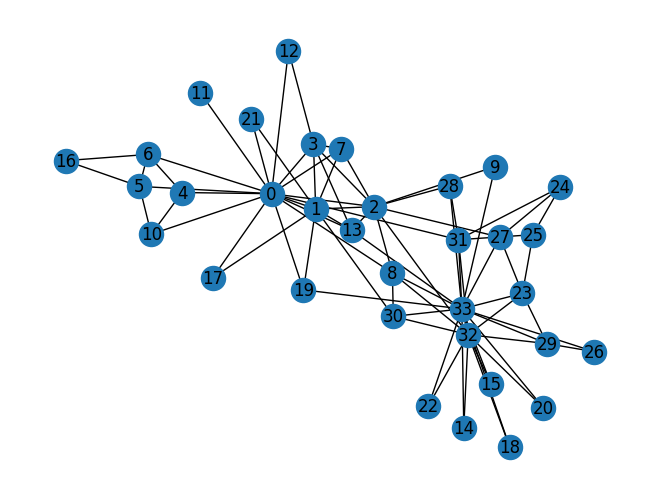

In [ ]:
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)

<a id='pred'></a>
### 2.B Computing the desired unsupervied predictors

``linkpred`` offers a wide number of unsupervied predictors organized into four families:
- **Neighborhood:**
    - *AdamicAdar*, AssociationStrength, *CommonNeighbours*, Cosine, DegreeProduct, *Jaccard*, MaxOverlap, MinOverlap, NMeasure, Pearson,ResourceAllocation
- **Paths:**
    - GraphDistance, *Katz*
- **Ranking:**
    - *SimRank*, RootedPageRank
- **Miscellanea:**
    - Community, Copy, *Random*
    
In the following we'll test only the ones seen in the lecture.

For sake of simplicity here we'll show only the top-5 forecasts for each selected predictor.

#### 2.B.1 Neighborhood

The first family of predictors is the one that tries to relate neighborhoods of node pairs with the likelihood of observing a tie among them. </br>
The question such predictors try to answer is: *How many friend we have to share in order to become friends?*

##### **Common Neighbors**

The more friends we share, the more likely we will become friends.

In [ ]:
cn = lp.predictors.CommonNeighbours(G, excluded=G.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(5)
for edge, score in top.items():
    print(edge, score)

33 - 2 6.0
33 - 0 4.0
13 - 7 4.0
33 - 1 3.0
32 - 28 3.0


##### **Jaccard**
The more similar our friends circles are, the more likely we will become friends.

In [ ]:
jc = lp.predictors.Jaccard(G, excluded=G.edges())
jc_results = jc.predict()

top = jc_results.top(5)
for edge, score in top.items():
    print(edge, score)

22 - 20 1.0
22 - 18 1.0
22 - 15 1.0
22 - 14 1.0
21 - 17 1.0


### **Adamic Adar**
The more selective our mutual friends are, the more likely we will become friends.

In [ ]:
aa = lp.predictors.AdamicAdar(G, excluded=G.edges())
aa_results = aa.predict()

top = aa_results.top(5)
for edge, score in top.items():
    print(edge, score)

33 - 2 4.719381261461351
33 - 0 2.7110197222973085
33 - 1 2.252921681630931
10 - 6 1.9922605072935597
5 - 4 1.9922605072935597


# Predicting Links with Graph Neural Networks

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Implementing a VGAE
- We will preprocess the dataset to remove links to predict randomly.
- We will create an encoder model that we will feed to a VGAE class, instead of directly implementing
a VGAE from scratch.

We create a transform object that normalizes input features, directly performs tensor device conversion, and randomly splits links. In this example, we have an 85/5/10 split. The add_negative_train_samples parameter is set to False because the model already
performs negative sampling, so it is not needed in the dataset:

In [ ]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False),
])



- We load the Cora dataset with the previous transform object:
- The RandomLinkSplit produces a train/val/test split by design. We store these splits as follows:

In [ ]:
dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

- Now, let’s implement the encoder. First, we need to import GCNConv and VGAE:
- We declare a new class. In this class, we want three GCN layers – a shared layer, a second layer to approximate mean values, μ , and a third layer to approximate variance values (in practice, the log standard deviation, log ):

In [ ]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

- We can initialize our VGAE and give the encoder as input. By default, it will use the inner product as a decoder.
- The train() function includes two important steps. First, the embedding matrix, , is computed using model.encode(); the name might be ounter-intuitive, but this function does sample embeddings from the learned distributions. Then, the ELBO loss is computed with model.recon_loss() (binary cross-entropy loss) and model.kl_loss() (KL divergence). The decoder is implicitly called to calculate the cross-entropy loss.
- The test() function simply calls the VGAE's dedicated method.

In [ ]:
model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)



- We train this model for 301 epochs and print the two built-in metrics – the AUC and the AP.
- We then evaluate our model on the test set.

In [ ]:
for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(test_data)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_data)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch  0 | Loss: 3.5473 | Val AUC: 0.6866 | Val AP: 0.7143
Epoch 50 | Loss: 1.3287 | Val AUC: 0.6699 | Val AP: 0.6941
Epoch 100 | Loss: 1.2086 | Val AUC: 0.7154 | Val AP: 0.7205
Epoch 150 | Loss: 1.1185 | Val AUC: 0.7610 | Val AP: 0.7500
Epoch 200 | Loss: 1.0035 | Val AUC: 0.8419 | Val AP: 0.8413
Epoch 250 | Loss: 0.9774 | Val AUC: 0.8527 | Val AP: 0.8550
Epoch 300 | Loss: 0.9592 | Val AUC: 0.8690 | Val AP: 0.8735
Test AUC: 0.8690 | Test AP 0.8735


- Finally, we can manually calculate the approximated adjacency matrix, $\hat{A}$

In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
Ahat = torch.sigmoid(z @ z.T)
Ahat

tensor([[0.7950, 0.6562, 0.8173,  ..., 0.4120, 0.8158, 0.7951],
        [0.6562, 0.8508, 0.8269,  ..., 0.3670, 0.7689, 0.7132],
        [0.8173, 0.8269, 0.8972,  ..., 0.3594, 0.8757, 0.8398],
        ...,
        [0.4120, 0.3670, 0.3594,  ..., 0.6587, 0.4050, 0.4049],
        [0.8158, 0.7689, 0.8757,  ..., 0.4050, 0.8656, 0.8319],
        [0.7951, 0.7132, 0.8398,  ..., 0.4049, 0.8319, 0.8047]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

## SEAL

- First, we import all the necessary libraries:

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse.csgraph import shortest_path

import torch.nn.functional as F
from torch.nn import Conv1d, MaxPool1d, Linear, Dropout, BCEWithLogitsLoss

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, aggr
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix

- We load the Cora dataset and apply a link-level random split, like in the previous section.
- The link-level random split creates new fields in the Data object to store the labels and index of each positive (real) and negative (fake) edge:

In [ ]:
# Load Cora dataset
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True)
dataset = Planetoid('.', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488], neg_edge_label=[4488], neg_edge_label_index=[2, 4488])

- We create a function to process each split and obtain enclosing subgraphs with one-hot encoded node labels and node features. We declare a list to store these subgraphs:

  1.   For each (source and destination) pair in the dataset, we extract the k-hop neighbors (here, = 2):
  2.   We calculate the distances using the DRNL function. First, we remove the target nodes from the subgraph:
  3.   We compute the adjacency matrices for source and destination nodes based on the previous subgraph:
  4.   We calculate the distance between every node and the source/destination target node:
  5.   We calculate the node labels, z, for every node in the subgraph:
  6.   concatenate features and one-hotencoded labels to build the node information matrix:
  7.   We create a Data object and append it to the list, which is the final output of this function:





In [ ]:
def seal_processing(dataset, edge_label_index, y):
    data_list = []

    for src, dst in edge_label_index.t().tolist():
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph([src, dst], 2, dataset.edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        # Double-radius node labeling (DRNL)
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(sub_edge_index, num_nodes=sub_nodes.size(0)).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        # Calculate the distance between every node and the source target node
        d_src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src)
        d_src = np.insert(d_src, dst, 0, axis=0)
        d_src = torch.from_numpy(d_src)

        # Calculate the distance between every node and the destination target node
        d_dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst-1)
        d_dst = np.insert(d_dst, src, 0, axis=0)
        d_dst = torch.from_numpy(d_dst)

        # Calculate the label z for each node
        dist = d_src + d_dst
        z = 1 + torch.min(d_src, d_dst) + dist // 2 * (dist // 2 + dist % 2 - 1)
        z[src], z[dst], z[torch.isnan(z)] = 1., 1., 0.
        z = z.to(torch.long)

        # Concatenate node features and one-hot encoded node labels (with a fixed number of classes)
        node_labels = F.one_hot(z, num_classes=200).to(torch.float)
        node_emb = dataset.x[sub_nodes]
        node_x = torch.cat([node_emb, node_labels], dim=1)

        # Create data object
        data = Data(x=node_x, z=z, edge_index=sub_edge_index, y=y)
        data_list.append(data)

    return data_list

 ##  enclosing subgraphs
 - Let’s use it to extract enclosing subgraphs for each dataset. We separate positive and negative examples to get the correct label to predict:

In [ ]:
# Enclosing subgraphs extraction
train_pos_data_list = seal_processing(train_data, train_data.pos_edge_label_index, 1)
train_neg_data_list = seal_processing(train_data, train_data.neg_edge_label_index, 0)

val_pos_data_list = seal_processing(val_data, val_data.pos_edge_label_index, 1)
val_neg_data_list = seal_processing(val_data, val_data.neg_edge_label_index, 0)

test_pos_data_list = seal_processing(test_data, test_data.pos_edge_label_index, 1)
test_neg_data_list = seal_processing(test_data, test_data.neg_edge_label_index, 0)

- Next, we merge positive and negative data lists to reconstruct the training, validation, and test datasets:
- We then create data loaders to train the GNN using batches:

In [ ]:
train_dataset = train_pos_data_list + train_neg_data_list
val_dataset = val_pos_data_list + val_neg_data_list
test_dataset = test_pos_data_list + test_neg_data_list

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

- We create a new class for the DGCNN model. The k parameter represents the number of nodes to hold for each subgraph:

In [ ]:
class DGCNN(torch.nn.Module):
    def __init__(self, dim_in, k=30):
        super().__init__()

        # GCN layers
        self.gcn1 = GCNConv(dim_in, 32)
        self.gcn2 = GCNConv(32, 32)
        self.gcn3 = GCNConv(32, 32)
        self.gcn4 = GCNConv(32, 1)

        # Global sort pooling
        self.global_pool = aggr.SortAggregation(k=k)

        # Convolutional layers
        self.conv1 = Conv1d(1, 16, 97, 97)
        self.conv2 = Conv1d(16, 32, 5, 1)
        self.maxpool = MaxPool1d(2, 2)

        # Dense layers
        self.linear1 = Linear(352, 128)
        self.dropout = Dropout(0.5)
        self.linear2 = Linear(128, 1)

    def forward(self, x, edge_index, batch):
        # 1. Graph Convolutional Layers
        h1 = self.gcn1(x, edge_index).tanh()
        h2 = self.gcn2(h1, edge_index).tanh()
        h3 = self.gcn3(h2, edge_index).tanh()
        h4 = self.gcn4(h3, edge_index).tanh()
        h = torch.cat([h1, h2, h3, h4], dim=-1)

        # 2. Global sort pooling
        h = self.global_pool(h, batch)

        # 3. Traditional convolutional and dense layers
        h = h.view(h.size(0), 1, h.size(-1))
        h = self.conv1(h).relu()
        h = self.maxpool(h)
        h = self.conv2(h).relu()
        h = h.view(h.size(0), -1)
        h = self.linear1(h).relu()
        h = self.dropout(h)
        h = self.linear2(h).sigmoid()

        return h

- We instantiate the model on a GPU if available, and train it using the Adam optimizer and the binary cross-entropy loss:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(train_dataset[0].num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred, y_true = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_pred.append(out.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    auc = roc_auc_score(torch.cat(y_true), torch.cat(y_pred))
    ap = average_precision_score(torch.cat(y_true), torch.cat(y_pred))

    return auc, ap



- We train the DGCNN for 31 epochs:
- Then we  test it on the test dataset:

In [ ]:
for epoch in range(4):
    loss = train()
    val_auc, val_ap = test(val_loader)
    print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_loader)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch  0 | Loss: 0.5731 | Val AUC: 0.8832 | Val AP: 0.8785
Epoch  1 | Loss: 0.5698 | Val AUC: 0.8895 | Val AP: 0.8884
Epoch  2 | Loss: 0.5657 | Val AUC: 0.8924 | Val AP: 0.8937
Epoch  3 | Loss: 0.5612 | Val AUC: 0.8951 | Val AP: 0.9012
Test AUC: 0.9039 | Test AP 0.9245


# Challenge

Test Variational Graph Autoencoder (VGAE) and the SEAL with the the facebook Page DataSet.

In [ ]:
#Your Solution
from torch_geometric.datasets import FacebookPagePage
dataset = FacebookPagePage(root=".")

data = dataset[0]

data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Print general information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: FacebookPagePage()
---------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4


In [ ]:
# Load Cora dataset
from torch_geometric.datasets import FacebookPagePage

transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True)
dataset = FacebookPagePage(root=".", transform=transform)
data = dataset[0]


train_data, val_data, test_data = data
train_data

Data(x=[22470, 128], edge_index=[2, 291008], y=[22470], pos_edge_label=[145504], pos_edge_label_index=[2, 145504], neg_edge_label=[145504], neg_edge_label_index=[2, 145504])

In [ ]:
# Enclosing subgraphs extraction
train_pos_data_list = seal_processing(train_data, train_data.pos_edge_label_index, 1)
train_neg_data_list = seal_processing(train_data, train_data.neg_edge_label_index, 0)

val_pos_data_list = seal_processing(val_data, val_data.pos_edge_label_index, 1)
val_neg_data_list = seal_processing(val_data, val_data.neg_edge_label_index, 0)

test_pos_data_list = seal_processing(test_data, test_data.pos_edge_label_index, 1)
test_neg_data_list = seal_processing(test_data, test_data.neg_edge_label_index, 0)

In [ ]:
train_dataset = train_pos_data_list + train_neg_data_list
val_dataset = val_pos_data_list + val_neg_data_list
test_dataset = test_pos_data_list + test_neg_data_list

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
#SEAL
model = DGCNN(train_dataset[0].num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred, y_true = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_pred.append(out.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    auc = roc_auc_score(torch.cat(y_true), torch.cat(y_pred))
    ap = average_precision_score(torch.cat(y_true), torch.cat(y_pred))

    return auc, ap



for epoch in range(31):
    loss = train()
    val_auc, val_ap = test(val_loader)
    print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_loader)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')